/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_33536/812775775.py:186: RuntimeWarning: invalid value encountered in divide
  occupancy_diffused > epsilon, spikes_diffused / occupancy_diffused, 0.0


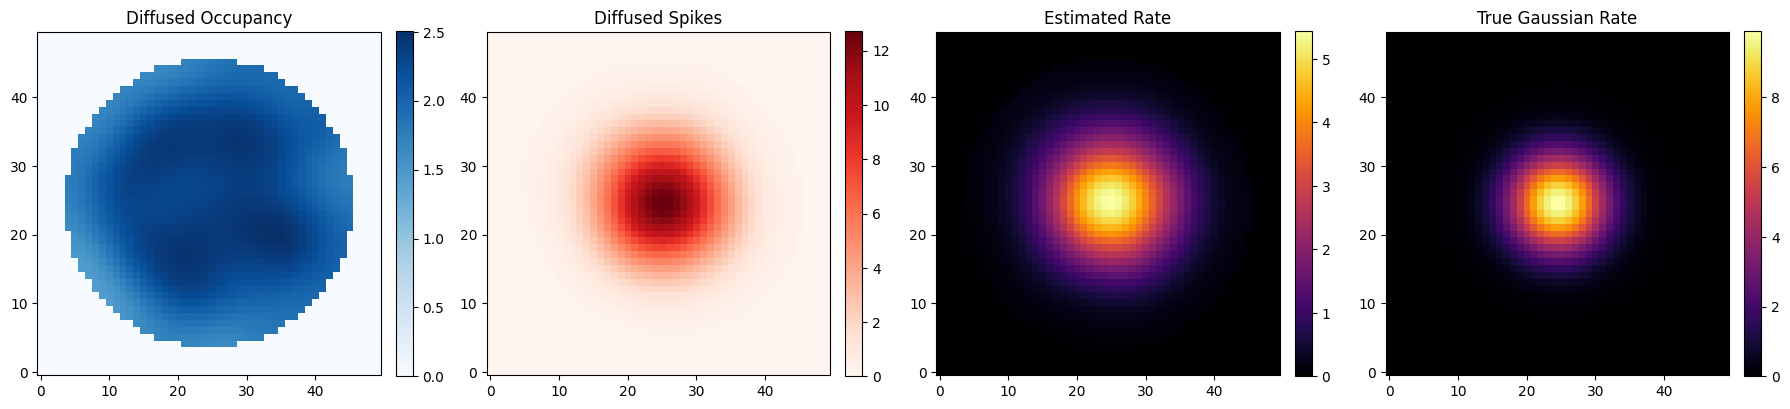

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# 1) Set up the circular track
# -----------------------------
def make_circular_track(nx=50, ny=50, radius=20):
    """
    Creates a circular region on a grid of size nx x ny.
    Returns:
      place_bin_centers: (nx, ny, 2) float array of bin center coordinates
      is_interior: (nx, ny) boolean array, True for interior bins
      is_boundary: (nx, ny) boolean array, True for bins adjacent to the interior
    """
    # For simplicity, define the edges at integer coordinates
    x_edges = np.arange(nx + 1)
    y_edges = np.arange(ny + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

    xx, yy = np.meshgrid(x_centers, y_centers, indexing="ij")
    place_bin_centers = np.stack([xx, yy], axis=-1)  # shape (nx, ny, 2)

    # Circle center
    center_x, center_y = nx / 2, ny / 2
    dist_sq = (xx - center_x) ** 2 + (yy - center_y) ** 2
    is_interior = dist_sq <= radius**2

    # Mark boundary bins that are adjacent (4-neighborhood) to interior bins
    is_boundary = np.zeros_like(is_interior, dtype=bool)
    shifts = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    for dx, dy in shifts:
        shifted = np.roll(is_interior, shift=dx, axis=0)
        shifted = np.roll(shifted, shift=dy, axis=1)
        boundary_candidate = ~is_interior & shifted
        is_boundary |= boundary_candidate

    return place_bin_centers, is_interior, is_boundary


# -------------------------------------------------
# 2) Convert positions to a grid-based density
# -------------------------------------------------
def positions_to_grid_density(positions, nx, ny, is_interior):
    """
    Converts an (N,2) array of positions into a 2D density of shape (nx, ny),
    incrementing 1 count in each visited bin. Only fills interior bins.
    """
    density = np.zeros((nx, ny), dtype=float)
    for x, y in positions:
        ix = int(round(x))
        iy = int(round(y))
        if 0 <= ix < nx and 0 <= iy < ny:
            if is_interior[ix, iy]:
                density[ix, iy] += 1.0
    return density


# -------------------------------------------------
# 3) Diffuse density under heat equation
# -------------------------------------------------
def diffuse_density(initial_density, is_interior, is_boundary, h, dt=0.1):
    """
    Diffuses a 2D density array using the heat equation with reflecting (Neumann)
    boundaries on the interior+boundary region. We integrate up to T = h^2
    with a simple forward-Euler scheme.

    initial_density: (nx, ny) array
    is_interior, is_boundary: (nx, ny) booleans
    h: bandwidth (diffusion time = h^2)
    dt: time step
    Returns:
      diffused: (nx, ny) array after diffusion
    """
    nx, ny = initial_density.shape
    diffused = initial_density.copy()

    T = h**2
    n_steps = int(np.ceil(T / dt))

    for _ in range(n_steps):
        new_density = diffused.copy()
        for i in range(nx):
            for j in range(ny):
                # Skip cells outside the domain
                if not (is_interior[i, j] or is_boundary[i, j]):
                    new_density[i, j] = 0.0
                    continue

                val_center = diffused[i, j]
                neighbors_sum = 0.0
                count_neighbors = 0
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + di, j + dj
                    if (
                        0 <= ni < nx
                        and 0 <= nj < ny
                        and (is_interior[ni, nj] or is_boundary[ni, nj])
                    ):
                        neighbors_sum += diffused[ni, nj]
                    else:
                        # Reflect across boundary => neighbor value = val_center
                        neighbors_sum += val_center
                    count_neighbors += 1
                laplacian = neighbors_sum - count_neighbors * val_center
                new_density[i, j] = val_center + dt * laplacian
        diffused = new_density
    return diffused


# ---------------------------------------------
# 4) Main simulation: known Gaussian rate
# ---------------------------------------------
def simulate_diffusion_method_gaussian():
    """
    1) Build a circular track on a 50x50 grid with radius=20.
    2) Define a Gaussian "true" rate function R(x,y).
    3) Sample occupant positions uniformly in the circle.
    4) For each occupant, draw spikes from Poisson(R(x,y)).
    5) Convert occupant/spike positions to 2D density arrays.
    6) Diffuse each density.
    7) Compute final rate map as diffused_spikes / diffused_occupancy.
    8) Compare with the known rate.
    """
    nx, ny = 50, 50
    radius = 20
    place_bin_centers, is_interior, is_boundary = make_circular_track(nx, ny, radius)

    # True Gaussian parameters
    x0, y0 = nx / 2, ny / 2
    sigma = 5.0
    A = 10.0  # peak amplitude

    def true_rate(x, y):
        return A * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2.0 * sigma**2))

    # -----------------------------
    # Sample occupant positions
    # -----------------------------
    n_occupancy = 3000
    # Extract valid interior bin centers
    valid_centers = place_bin_centers[is_interior]
    # Choose random interior bins to simulate uniform coverage
    occ_idx = np.random.choice(len(valid_centers), size=n_occupancy, replace=True)
    occupancy_positions = valid_centers[occ_idx]

    # -----------------------------
    # Sample spikes from Poisson
    # -----------------------------
    # For each occupant position, let the expected # spikes = R(x,y).
    # We'll allow fractional values, but Poisson() internally rounds to integer draws.
    # Summation across all occupants yields total spikes in each location.
    spike_positions_list = []
    for pos in occupancy_positions:
        lam = true_rate(pos[0], pos[1])
        spike_count = np.random.poisson(lam)
        if spike_count > 0:
            # If multiple spikes occur, store the position multiple times
            spike_positions_list.extend([pos] * spike_count)
    spike_positions = np.array(spike_positions_list)

    # -----------------------------
    # Make 2D density grids
    # -----------------------------
    occupancy_init = positions_to_grid_density(occupancy_positions, nx, ny, is_interior)
    spikes_init = positions_to_grid_density(spike_positions, nx, ny, is_interior)

    # -----------------------------
    # Diffuse each density
    # -----------------------------
    bandwidth = 3.0  # example bandwidth
    dt = 0.1
    occupancy_diffused = diffuse_density(
        occupancy_init, is_interior, is_boundary, bandwidth, dt
    )
    spikes_diffused = diffuse_density(
        spikes_init, is_interior, is_boundary, bandwidth, dt
    )

    # -----------------------------
    # Compute final rate estimate
    # -----------------------------
    epsilon = 1e-9
    rate_map = np.where(
        occupancy_diffused > epsilon, spikes_diffused / occupancy_diffused, 0.0
    )

    # -----------------------------
    # Compute the "true" rate over the grid
    # -----------------------------
    XX = place_bin_centers[..., 0]
    YY = place_bin_centers[..., 1]
    true_rate_map = true_rate(XX, YY)
    true_rate_map[~(is_interior | is_boundary)] = 0.0

    # -----------------------------
    # Plot results
    # -----------------------------
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    im0 = axs[0].imshow(occupancy_diffused.T, origin="lower", cmap="Blues")
    axs[0].set_title("Diffused Occupancy")
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(spikes_diffused.T, origin="lower", cmap="Reds")
    axs[1].set_title("Diffused Spikes")
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(rate_map.T, origin="lower", cmap="inferno")
    axs[2].set_title("Estimated Rate")
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    im3 = axs[3].imshow(true_rate_map.T, origin="lower", cmap="inferno")
    axs[3].set_title("True Gaussian Rate")
    plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    simulate_diffusion_method_gaussian()